# CycleGAN Implementation
Antonio Karam (akaram@nd.edu)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ResnetBlock class (already provided)
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []
        conv_block += [nn.ReflectionPad2d(1), nn.Conv2d(dim, dim, kernel_size=3, padding=0), nn.InstanceNorm2d(dim), nn.ReLU(True)]
        conv_block += [nn.ReflectionPad2d(1), nn.Conv2d(dim, dim, kernel_size=3, padding=0), nn.InstanceNorm2d(dim)]
        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

# Updated Generator class using ResnetBlock
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),  # Initial convolution
            nn.InstanceNorm2d(64),  # Normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Downsample
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Downsample
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
            # Residual blocks
            *[ResnetBlock(256) for _ in range(9)],  # Use ResnetBlock here
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsample
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsample
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),  # Final convolution
            nn.Tanh()  # Output layer
        )

    def forward(self, x):
        return self.model(x)

# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # Output layer
        )

    def forward(self, x):
        return self.model(x)

# Define Adversarial Loss
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True):
        super(GANLoss, self).__init__()
        self.loss = nn.MSELoss() if use_lsgan else nn.BCEWithLogitsLoss()

    def forward(self, prediction, target_is_real):
        target_tensor = torch.ones_like(prediction) if target_is_real else torch.zeros_like(prediction)
        loss = self.loss(prediction, target_tensor)
        return loss

# Define Cycle Consistency Loss
def cycle_consistency_loss(real_image, reconstructed_image, lambda_weight=10.0):
    loss = nn.L1Loss()(reconstructed_image, real_image)
    return lambda_weight * loss

# Define the full CycleGAN model
class CycleGAN(nn.Module):
    def __init__(self):
        super(CycleGAN, self).__init__()
        self.gen_A2B = Generator()  # Generator from domain A to domain B
        self.gen_B2A = Generator()  # Generator from domain B to domain A
        self.disc_A = Discriminator()  # Discriminator for domain A
        self.disc_B = Discriminator()  # Discriminator for domain B
        self.gan_loss = GANLoss()  # Adversarial loss
        self.lambda_cycle = 10.0  # Cycle consistency weight

    def forward(self, real_A, real_B):
        # Generate fake images
        fake_B = self.gen_A2B(real_A)
        fake_A = self.gen_B2A(real_B)
        # Reconstruct images
        cycle_A = self.gen_B2A(fake_B)
        cycle_B = self.gen_A2B(fake_A)

        # Return generated and reconstructed images
        return fake_A, fake_B, cycle_A, cycle_B

    def compute_loss(self, real_A, real_B):
        fake_A, fake_B, cycle_A, cycle_B = self.forward(real_A, real_B)

        # Calculate the adversarial losses
        loss_G_A2B = self.gan_loss(self.disc_B(fake_B), True)
        loss_G_B2A = self.gan_loss(self.disc_A(fake_A), True)

        # Calculate cycle consistency losses
        loss_cycle_A = cycle_consistency_loss(real_A, cycle_A, self.lambda_cycle)
        loss_cycle_B = cycle_consistency_loss(real_B, cycle_B, self.lambda_cycle)

        # Total generator loss
        loss_G = loss_G_A2B + loss_G_B2A + loss_cycle_A + loss_cycle_B

        # Calculate the discriminator losses
        loss_D_A = self.gan_loss(self.disc_A(real_A), True) + self.gan_loss(self.disc_A(fake_A.detach()), False)
        loss_D_B = self.gan_loss(self.disc_B(real_B), True) + self.gan_loss(self.disc_B(fake_B.detach()), False)

        # Total discriminator loss
        loss_D = loss_D_A + loss_D_B

        return loss_G, loss_D


## Training and Testing the CycleGAN Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

# Use A100 GPU
device = torch.device("cuda")

# Define the Dataset class
class UnpairedImageDataset(Dataset):
    def __init__(self, root_A, root_B, transform=None):
        """
        Initialize the dataset with paths to domain A and domain B images.

        Args:
            root_A (str): Path to the images in domain A.
            root_B (str): Path to the images in domain B.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.A_images = sorted(os.listdir(root_A))
        self.B_images = sorted(os.listdir(root_B))
        self.root_A = root_A
        self.root_B = root_B
        self.transform = transform

    def __len__(self):
        return max(len(self.A_images), len(self.B_images))

    def __getitem__(self, idx):
        A_img_path = os.path.join(self.root_A, self.A_images[idx % len(self.A_images)])
        B_img_path = os.path.join(self.root_B, self.B_images[idx % len(self.B_images)])

        A_img = Image.open(A_img_path).convert("RGB")
        B_img = Image.open(B_img_path).convert("RGB")

        if self.transform:
            A_img = self.transform(A_img)
            B_img = self.transform(B_img)

        return A_img, B_img

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
print(f"Using device: {device}")
# Dataset class and DataLoader for batch size 8
dataset = UnpairedImageDataset(root_A='/content/drive/MyDrive/ML/HW01/data/trainA', root_B='/content/drive/MyDrive/ML/HW01/data/trainB', transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

# Initialize the CycleGAN model
cyclegan = CycleGAN()
cyclegan.to(device)  # Move model to device

# Define optimizers
optimizer_G = optim.Adam(list(cyclegan.gen_A2B.parameters()) + list(cyclegan.gen_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(list(cyclegan.disc_A.parameters()) + list(cyclegan.disc_B.parameters()), lr=0.0002, betas=(0.5, 0.999))

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    for i, (real_A, real_B) in enumerate(dataloader):
        real_A = real_A.to(device)
        real_B = real_B.to(device)

        # Zero the generator gradients
        optimizer_G.zero_grad()
        optimizer_D.zero_grad()

        # Compute the generator loss
        loss_G, loss_D = cyclegan.compute_loss(real_A, real_B)

        # Backpropagate and optimize the generator
        loss_G.backward()
        optimizer_G.step()

        # Backpropagate and optimize
        loss_D.backward()
        optimizer_D.step()

        # Print training progress
        if i % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], Loss_G: {loss_G.item()}, Loss_D: {loss_D.item()}')


    torch.save(cyclegan.state_dict(), f'cyclegan_epoch_{epoch}.pth')

Using device: cuda
Epoch [0/100], Step [0/154], Loss_G: 12.572322845458984, Loss_D: 2.2800240516662598
Epoch [0/100], Step [100/154], Loss_G: 6.516125679016113, Loss_D: 1.046770453453064
Epoch [1/100], Step [0/154], Loss_G: 4.621391296386719, Loss_D: 0.84555983543396
Epoch [1/100], Step [100/154], Loss_G: 4.524366855621338, Loss_D: 1.008098840713501
Epoch [2/100], Step [0/154], Loss_G: 5.810151100158691, Loss_D: 0.8133955597877502
Epoch [2/100], Step [100/154], Loss_G: 4.738038063049316, Loss_D: 1.0394208431243896
Epoch [3/100], Step [0/154], Loss_G: 5.368709087371826, Loss_D: 1.0518121719360352
Epoch [3/100], Step [100/154], Loss_G: 4.507268905639648, Loss_D: 1.3941344022750854
Epoch [4/100], Step [0/154], Loss_G: 4.089493274688721, Loss_D: 1.0919015407562256
Epoch [4/100], Step [100/154], Loss_G: 4.594815254211426, Loss_D: 1.0023608207702637
Epoch [5/100], Step [0/154], Loss_G: 3.783627986907959, Loss_D: 0.874800443649292
Epoch [5/100], Step [100/154], Loss_G: 3.5442264080047607, Los

In [ ]:
# Load the CycleGAN model from the last epoch
cyclegan.load_state_dict(torch.load('cyclegan_epoch_99.pth', weights_only=True))

# Define test datasets and dataloaders
test_dataset = UnpairedImageDataset(root_A='/content/drive/MyDrive/ML/HW01/data/testA', root_B='/content/drive/MyDrive/ML/HW01/data/testB', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

# Testing and Visualization
def visualize_results(real_A, real_B, fake_B, fake_A):
    """Function to visualize real and generated images."""
    plt.figure(figsize=(12, 6))

    # Real images
    plt.subplot(1, 4, 1)
    plt.imshow((real_A[0].permute(1, 2, 0).cpu().numpy() + 1) / 2)  # Unnormalize
    plt.title("Input Image (Real A)")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow((real_B[0].permute(1, 2, 0).cpu().numpy() + 1) / 2)  # Unnormalize
    plt.title("Input Image (Real B)")
    plt.axis("off")

    # Generated images
    plt.subplot(1, 4, 3)
    plt.imshow((fake_B[0].permute(1, 2, 0).cpu().numpy() + 1) / 2)  # Unnormalize
    plt.title("Translated Image (Fake B)")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow((fake_A[0].permute(1, 2, 0).cpu().numpy() + 1) / 2)  # Unnormalize
    plt.title("Reconstructed Image (Fake A)")
    plt.axis("off")

    plt.show()

cyclegan.eval()
with torch.no_grad():
    for i, (real_A, real_B) in enumerate(test_dataloader):
        if i > 5:  # Display results for 5 examples
            break
        real_A = real_A.to('cuda')
        real_B = real_B.to('cuda')
        fake_B, fake_A, _, _ = cyclegan.forward(real_A, real_B)

        visualize_results(real_A, real_B, fake_B, fake_A)


cyclegan.eval()
with torch.no_grad():
    for i, (real_A, real_B) in enumerate(test_dataloader):
        real_A = real_A.to('cuda')
        real_B = real_B.to('cuda')
        fake_B, fake_A, _, _ = cyclegan.forward(real_A, real_B)

        visualize_results(real_A, real_B, fake_B, fake_A)

        # Display results for a fixed number of examples
        if i >= 5:  # Display results for 5 examples
            break


Output hidden; open in https://colab.research.google.com to view.

<ipython-input-9-98a808601434>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cyclegan.load_state_dict(torch.load('cyclegan_epoch_99.pth'))  # Replace with the correct mo

Saving 1000_F_331866919_R8kBbizyn9cq1vnVFQKVQZlcBbO7b2ls.jpg to 1000_F_331866919_R8kBbizyn9cq1vnVFQKVQZlcBbO7b2ls.jpg


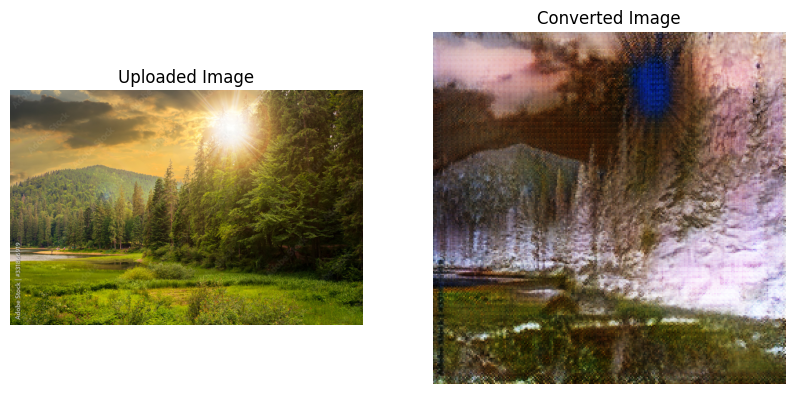

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

# Function to upload and load an image
def upload_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        image = Image.open(filename).convert("RGB")
        return image
    return None

# Preprocessing function
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to convert tensor back to an image
def tensor_to_image(tensor):
    tensor = tensor.cpu().squeeze(0)
    tensor = tensor * 0.5 + 0.5  # Unnormalize
    return tensor.permute(1, 2, 0).numpy()

# Load a pretrained CycleGAN model
cyclegan = CycleGAN()
cyclegan.load_state_dict(torch.load('cyclegan_epoch_99.pth'))  # Replace with the correct model file
cyclegan.to('cuda')
cyclegan.eval()

# Upload and process the image
uploaded_image = upload_image()
if uploaded_image is not None:
    input_image = preprocess_image(uploaded_image).to('cuda')

    # Choose the translation direction
    with torch.no_grad():
        # Translate from domain A to B
        fake_image = cyclegan.gen_A2B(input_image)  # Change to gen_B2A if you want

    # Convert tensor back to an image for display
    output_image = tensor_to_image(fake_image)

    # Display the uploaded and converted images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(uploaded_image)
    axs[0].set_title("Uploaded Image")
    axs[0].axis('off')

    axs[1].imshow(output_image)
    axs[1].set_title("Converted Image")
    axs[1].axis('off')

    plt.show()
else:
    print("No image was uploaded.")


## Reflection and Summary

 - Training and Performance Challenges: The hardest part of the project was figuring out where to train the CycleGAN model and how to do it efficiently. Initially, I attempted to train it on my MacBook Air with the M2 chip, but I quickly realized it was incompatible with CUDA, which is essential for GPU acceleration in PyTorch. Without CUDA support, training would have been much slower, so I had to explore other options. Next, I decided to train the model on Google Colab, where I could leverage the provided GPU. However, even with a GPU, training the model took over 10 hours. This long training time can be attributed to the complexity of CycleGAN, which requires two generators and two discriminators, along with calculating cycle consistency loss, making the model computationally expensive. The challenge taught me the importance of selecting a proper hardware environment for deep learning tasks and planning ahead for resource-heavy models like CycleGAN.

 - Potential Improvements: One potential improvement that could enhance CycleGAN's performance is using a more efficient generator architecture, like replacing standard convolutional layers with residual blocks or using attention mechanisms. Residual blocks help preserve information and stabilize training by allowing the network to learn identity mappings, which can make it easier for the model to maintain content while applying style transformations. Attention mechanisms could help focus the network's resources on the most relevant parts of the image, improving both style transfer and content preservation, leading to better visual quality of the generated images. This could also reduce the number of epochs needed for convergence, speeding up the overall training process.